# Examen Unidad 3

**Integrantes**

Acosta López Roberto Ismael - 18111958 \
Gaytan Bañuelos Ángel - 18111893 \
Valenzuela Rodriguez Axel Alejandro - 18111978 

## Importando librerias

Importamos las librerias que utilizaremos para todo el documento.

In [195]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
#from sklearn.preprocessing import Normalizer

# Detección de valores atipicos
from pyod.models.knn import KNN



from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 
from sklearn.model_selection import train_test_split 


from sklearn.linear_model import LogisticRegression

# Librerias de prueba
# Para clasificación 

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC # Máquinas de vectores de soporte
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#Evaluacion de rendimiento 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score 

Configuramos opciones de visualización tanto para los datos como para las graficas

In [196]:
#pd.options.display.max_columns = 10
#pd.options.display.max_rows = 10

## Cargando Dataset

In [197]:
df = pd.read_csv('Financial-Data.csv')
df_original = df

### Información sobre el dataset

El Dataset utilizado contiene una serie de registros de personas que solicitaron una Firma electrónica de préstamo, donde se hace un conteo de las personas que finalizaron el proceso de la Firma electronica haciendo una comparacion basada en su historial financiero.

Mediante esto se planea desarrollar un modelo de predicción el cual permita, mediante su historial financiero, laboral y datos personales extras, si es que la persona completara o no su proceso de Firma electronica.

### Contenido de las columnas:
El archivo CVS contiene detalles de usuarios los cuales comenzaron el proceso de Firma Electronica, teniendo resultados donde se finalizo el proceso, y otros donde el proceso no se concluyo correctamente. 

* **ID**: 
    Identificación del usuario - Cliente

* **Edad**: 
    Edad del usuario 

* **Tipo_de_salario**: 
    Con qué frecuencia se les paga a los solicitantes

* **Vivienda_propia**:
    * 0 = Vivienda alquilada
    * 1 = Propietario

* **Ingreso**: 
    Ingresos del solicitante

* **Tiempo_trabajado(meses)**:
    Cuantos meses lleva haciendo trabajo

* **Tiempo_trabajado(años)**:
    Cuantos años lleva haciendo trabajo 

* **Tiempo_en_vivienda_actual(años)**:
    Cuántos años se quedó una persona en la dirección actual

* **Tiempo_cuenta_personal(meses)**:
    Cuantos meses tiene esa persona una cuenta personal

* **Tiempo_cuenta_personal(años)**:
    Cuantos meses tiene esa persona una cuenta personal 

* **Tiene_deuda**:
    La persona tiene alguna deuda o no.

* **Cantidad_solicitada**:
    El usuario decidió solicitar

* **Puntuación_de_riesgo (Columnas de la 1 a la 5)**: 
    Quien sabe

* **ext-quality_score (Columnas de la 1 a la 2)**: 
    Quien sabe

* **consultas_el_mes_pasado**:
    Cuantas consultas ha tenido el usuario en los últimos meses

* Proceso_firma_electronica_completado (**Columna objetivo**):
    * 1: Proceso de firma electrónica completado
    * 0: No completado el proceso de firma electrónica


### Detalles del dataset:
1. Los nombres de las columnas del dataset fueron interpretadas al español, para facilitar su comprensión.

### Meta Objetivo:
El objetivo principal es crear distintos metodos de predicción para intentar predecir si el solicitante completará el proceso de firma electrónica o no.

### Método de resolución:
La problematica planteada se puede resolver bajo un modelo de clasificación.

## Entendiendo los datos

### Verificar los datos
Mediante el uso del método head podremos ver la informacion de las primeras 5 filas de datos de cada columna.

In [198]:
df.head()

,ID,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),...,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
0,7629673,40,bi-weekly,1,3135,0,3,3,6,2,...,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,3560428,61,weekly,0,3180,0,6,3,2,7,...,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,6934997,23,weekly,0,1540,6,0,0,7,1,...,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0
3,5682812,40,bi-weekly,0,5230,0,6,1,2,7,...,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,1
4,5335819,33,semi-monthly,0,3590,0,5,2,2,8,...,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0


### Eliminación de la columna ID
Podemos observar que la columna ID solo almacena el indice de cada uno de los datos, no forma parte de información relevante para aplicarlo en nuestro ejercicio, por lo que decidimos quitarla de la columna.

In [199]:
df.drop(columns=['ID'], inplace=True)
df.head()


,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
0,40,bi-weekly,1,3135,0,3,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,61,weekly,0,3180,0,6,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,23,weekly,0,1540,6,0,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0
3,40,bi-weekly,0,5230,0,6,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,1
4,33,semi-monthly,0,3590,0,5,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0


# Explicar que entendemos de las columnas y que podriamos cambiar

### Dimensionando los datos
Se puede observar mediante la función shape que se tiene en el dataset un total de 20 columnas, con un total de mas de 17908 registros en ellos.

In [201]:
df.shape

(17908, 20)

### Tipos de datos
Para saber que tipo de datos es la que tiene cada una de las columnas aplicamos el método dtypes.

In [202]:
df.dtypes

Edad                                      int64
Tipo_de_salario                          object
Vivienda_propia                           int64
Ingreso                                   int64
Tiempo_trabajado(meses)                   int64
Tiempo_trabajado(anos)                    int64
Tiempo_en_vivienda_actual(anos)           int64
Tiempo_cuenta_personal(meses)             int64
Tiempo_cuenta_personal(anos)              int64
Adeudos                                   int64
Cantidad_solicitada                       int64
Puntuacion_de_riesgo                      int64
Puntuacion_de_riesgo_2                  float64
Puntuacion_de_riesgo_3                  float64
Puntuacion_de_riesgo_4                  float64
Puntuacion_de_riesgo_5                  float64
ext_quality_score                       float64
ext_quality_score_2                     float64
consultas_el_mes_pasado                   int64
Proceso_firma_electronica_completado      int64
dtype: object

# Explicar cada dato porque es asi 

### Descripción estadística
Mediante el uso de un describe podremos ver la informacion de los datos numericos estadisticos (Conteo, Media, Desviación estandar, Minimos, Maximos, y los cuartiles por defecto [25, 50, 75]).

Se presenta primeramente para los datos de tipo númerico

In [203]:
df.describe()

,Edad,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
count,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000,17908.000000
mean,43.015412,0.425173,3657.214653,1.186006,3.526860,3.584711,3.427183,3.503350,0.795399,950.446449,61086.302211,0.690878,0.878276,0.583155,0.718252,0.623112,0.622068,6.457226,0.538251
std,11.873107,0.494383,1504.890063,2.400897,2.259732,2.751937,2.216440,1.955568,0.403421,698.543683,15394.255020,0.090470,0.054563,0.125061,0.120697,0.139729,0.139898,3.673093,0.498549
min,18.000000,0.000000,905.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,350.000000,2100.000000,0.023258,0.451371,0.016724,0.153367,0.010184,0.006622,1.000000,0.000000
25%,34.000000,0.000000,2580.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,600.000000,49350.000000,0.640993,0.850882,0.500208,0.633708,0.521735,0.519677,4.000000,0.000000
50%,42.000000,0.000000,3260.000000,0.000000,3.000000,3.000000,2.000000,3.000000,1.000000,700.000000,61200.000000,0.699561,0.881004,0.588208,0.725113,0.625944,0.622973,6.000000,1.000000
75%,51.000000,1.000000,4670.000000,1.000000,5.000000,5.000000,5.000000,4.000000,1.000000,1100.000000,72750.000000,0.752887,0.912608,0.672395,0.806681,0.729841,0.728940,8.000000,1.000000
max,96.000000,1.000000,9985.000000,11.000000,16.000000,12.000000,11.000000,15.000000,1.000000,10200.000000,99750.000000,0.999997,0.999024,0.978932,0.996260,0.970249,0.966953,30.000000,1.000000


# Explicar el cuadro de arriba

Y para los datos de tipo texto

In [204]:
df.describe(include=[object])

,Tipo_de_salario
count,17908
unique,4
top,bi-weekly
freq,10716


Como podemos observar, la columna salario maneja solamente 4 valores unicos dentro de la columna, asi que la información manejada es de tipo categorica. La frecuencia de su top, que es bi-weekly, o en español quincenal, es de 10716 registros, por lo que aproximadamente el **60%** del dataset incluyo personas que realizaron el proceso de firma electronica, que en sus trabajos su pago es quincenal. 

### Distribución de clases

Observamos como se distribuyen los datos de la columna independiente(objetivo).

In [205]:
conteo_df = df.groupby("Proceso_firma_electronica_completado").size()
conteo_df

Proceso_firma_electronica_completado
0    8269
1    9639
dtype: int64

Observamos que los datos recopilados en el dataset nos muestra que contiene el **46%** de personas que no completaron el proceso, mientras que el **54%** si lo completo.

Podemos decir que los datos se encuentran balanceados, asi que no tendremos problemas para confiar en la precisión de nuestro clasificador.

## Preprocesamiento 

### Label Encoder

Vemos cuantos valores unicos presenta la columna Tipo de salario

In [206]:
df.Tipo_de_salario.unique()

array(['bi-weekly', 'weekly', 'semi-monthly', 'monthly'], dtype=object)

Viendo la información del arreglo, vemos que contamos con una columna que maneja texto y solo se repiten unos cuantos datos, por lo que podriamos considerarla de tipo categorica.

Lo que vamos a hacer con ella sera aplicar el método label encoder para almacenar los datos exclusivamente numericos en el dataframe.

In [207]:
le = LabelEncoder()
le.fit(df['Tipo_de_salario'])
le.classes_

array(['bi-weekly', 'monthly', 'semi-monthly', 'weekly'], dtype=object)

Despues de ajustar los datos, transformamos los datos de la columna y los guardamos nuevamente, esta vez, con los datos ya etiquetados.

In [208]:
datos_le = le.transform(df['Tipo_de_salario'])
df['Tipo_de_salario'] = datos_le
df.head()

,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
0,40,0,1,3135,0,3,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,61,3,0,3180,0,6,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,23,3,0,1540,6,0,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0
3,40,0,0,5230,0,6,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,1
4,33,2,0,3590,0,5,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0


### Valores atipicos - Método KNN (K vecinos más cercanos)

Utilizaremos la clase kNN para la detección de valores atípicos. Como funciona este algoritmo, mide la densidad entre los datos. Para una observación, mide su distancia a su k-ésimo vecino más cercano, si existen valores entre el que se encuentran en el rango aceptado los considerara y los agrupara, en caso contrario los considerara valores atipicos.

Para su uso, utiliza un puntaje para identificar los valores atipicos, en este caso, la clase acepta tres, nosotros utilizaremos el método de promedio para evaluar el puntaje con los vecinos, también consideraremos que tenemos una contaminación, es decir, la proporción de valores atípicos en el conjunto de datos. Este algoritmo considera que el dataset completo tiene como máximo un **50%** como datos con valores atipicos. En nuestro caso, colocamos de forma arbitraria una contaminación del **18%**. 

In [209]:
clf = KNN(contamination=0.18, method='mean')
clf.fit(df.drop(columns=['Tipo_de_salario','Proceso_firma_electronica_completado']))
atipicos_pred = clf.predict(df.drop(columns=['Tipo_de_salario','Proceso_firma_electronica_completado']))

Aplicando el algoritmo vemos que considero que nuestro dataset presenta 17908 elementos que los considera atipicos dentro del modelo, aplicando el método en base a la media de los elementos.

In [210]:
len(atipicos_pred)

17908

Una vez realizado la predicción de valores atipicos los guardaremos en un dataframe aparte

In [211]:
df_outliers = df[atipicos_pred == 1]
df_outliers

,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
14,50,0,0,3700,0,2,6,2,1,1,500,2800,0.467041,0.809313,0.624904,0.621841,0.462823,0.462823,16,1
17,58,3,1,3675,0,10,10,2,0,1,400,29150,0.691881,0.833958,0.765912,0.754194,0.824777,0.624777,9,1
46,46,0,0,4548,0,3,3,2,4,1,2000,72400,0.598292,0.900184,0.617605,0.753998,0.591933,0.391933,23,1
62,33,0,1,6560,0,3,2,5,2,1,400,30450,0.731881,0.932775,0.492736,0.818069,0.556111,0.656111,12,1
73,36,2,1,2295,4,4,7,2,1,1,550,21150,0.269270,0.756464,0.351737,0.771519,0.454607,0.454607,9,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17843,42,3,0,2570,0,5,2,4,8,1,2200,63950,0.678887,0.910251,0.552782,0.842766,0.460111,0.460111,3,0
17868,44,0,1,8145,0,5,10,4,7,1,5100,80850,0.666673,0.947376,0.751581,0.896817,0.690225,0.590225,5,0
17870,57,0,1,8040,10,6,1,10,7,1,400,64500,0.760294,0.911497,0.621489,0.953953,0.648045,0.948045,6,1
17878,48,2,1,7155,6,2,7,6,8,1,1300,77050,0.638645,0.848469,0.471878,0.632073,0.562237,0.762237,2,1


Y los eliminamos de los datos actuales

In [212]:
df = df[atipicos_pred == 0]
df

,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
0,40,0,1,3135,0,3,3,6,2,1,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,61,3,0,3180,0,6,3,2,7,1,600,30150,0.738510,0.881027,0.713423,0.826402,0.730720,0.630720,9,0
2,23,3,0,1540,6,0,0,7,1,1,450,34550,0.642993,0.766554,0.595018,0.762284,0.531712,0.531712,7,0
3,40,0,0,5230,0,6,1,2,7,1,700,42150,0.665224,0.960832,0.767828,0.778831,0.792552,0.592552,8,1
4,33,2,0,3590,0,5,2,2,8,1,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17903,31,1,0,3245,0,5,3,2,6,1,700,71700,0.691126,0.928196,0.664112,0.838012,0.727705,0.627705,2,0
17904,46,0,0,6525,0,2,1,3,3,1,800,51800,0.648525,0.970832,0.699241,0.844724,0.774918,0.474918,3,0
17905,46,3,0,2685,0,5,1,1,8,1,1200,59650,0.677975,0.918141,0.687981,0.939101,0.472045,0.672045,9,0
17906,42,0,0,2515,0,3,5,6,1,1,400,80200,0.642741,0.885684,0.456448,0.686823,0.406568,0.406568,3,1


## Estandarización de los datos

### ¿Qué es la estandarización?

Es el proceso que corresponde a igualar la información de diferentes fuentes (en este caso de columnas) en una misma escala.

### ¿Para qué sirve?

* Permite asegurarnos de que tendremos datos útiles y fácilmente utilizables para cualquier proceso de analisis.
* Le damos uniformidad a los datos, con el fin de que la escala de estos influya en el proceso de algún algoritmo.



In [213]:
sc = StandardScaler()
df_estandarizar = df[['Edad','Ingreso','Tiempo_trabajado(meses)','Tiempo_trabajado(anos)','Tiempo_en_vivienda_actual(anos)','Tiempo_cuenta_personal(meses)','Tiempo_cuenta_personal(anos)','Cantidad_solicitada','Puntuacion_de_riesgo','Puntuacion_de_riesgo_2','Puntuacion_de_riesgo_3','Puntuacion_de_riesgo_4','Puntuacion_de_riesgo_5','ext_quality_score','ext_quality_score_2','consultas_el_mes_pasado']]
datos_estandarizados = sc.fit_transform(df_estandarizar)
df_estandar = pd.DataFrame(data = datos_estandarizados, columns= df_estandarizar.columns )
df_estandar.head()

,Edad,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado
0,-0.225199,-0.252059,-0.498181,-0.214983,-0.203549,1.142375,-0.772647,-0.615650,-1.644706,0.515930,0.472052,-0.748358,-1.659955,-0.300449,-1.736552,0.969129
1,1.542596,-0.216595,-0.498181,1.121765,-0.203549,-0.650836,1.811407,-0.504402,-2.057400,0.528284,0.057394,1.057034,0.908993,0.779208,0.066139,0.695965
2,-1.656271,-1.509064,1.999371,-1.551731,-1.300135,1.590677,-1.289458,-0.838147,-1.757259,-0.533094,-2.053139,0.109945,0.378379,-0.655088,-0.648350,0.149636
3,-0.225199,1.398990,-0.498181,1.121765,-0.934606,-0.650836,1.811407,-0.281905,-1.238834,-0.286072,1.528766,1.492200,0.515315,1.224845,-0.209299,0.422800
4,-0.814464,0.106522,-0.498181,0.676183,-0.569077,-0.650836,2.328218,0.608080,-0.440733,-0.817915,-0.375265,0.257671,-0.422369,0.879489,0.888197,1.515458


No lo aplicamos a las columnas: 
* Tipo de salario 

Debido a que son valores etiquetados, no tendria sentido agregarlos.

* Vivienda propia
* Adeudos

Ya que se tratan de valores binarios, o lo tienen (1) o no lo tienen (0).

* Proceso de firma electronica completado

Ya que es de tipo binaria, ademas se trata de nuestra variable objetivo.



Cambiamos los datos a los estandarizados en el dataframe

In [215]:
df[df_estandar.columns] = df_estandar.values
df.head()

C:\Users\Ismael\AppData\Local\Temp\ipykernel_8672\1903354113.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df_estandar.columns] = df_estandar.values


,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
0,-0.225199,0,1,-0.252059,-0.498181,-0.214983,-0.203549,1.142375,-0.772647,1,-0.615650,-1.644706,0.515930,0.472052,-0.748358,-1.659955,-0.300449,-1.736552,0.969129,1
1,1.542596,3,0,-0.216595,-0.498181,1.121765,-0.203549,-0.650836,1.811407,1,-0.504402,-2.057400,0.528284,0.057394,1.057034,0.908993,0.779208,0.066139,0.695965,0
2,-1.656271,3,0,-1.509064,1.999371,-1.551731,-1.300135,1.590677,-1.289458,1,-0.838147,-1.757259,-0.533094,-2.053139,0.109945,0.378379,-0.655088,-0.648350,0.149636,0
3,-0.225199,0,0,1.398990,-0.498181,1.121765,-0.934606,-0.650836,1.811407,1,-0.281905,-1.238834,-0.286072,1.528766,1.492200,0.515315,1.224845,-0.209299,0.422800,1
4,-0.814464,2,0,0.106522,-0.498181,0.676183,-0.569077,-0.650836,2.328218,1,0.608080,-0.440733,-0.817915,-0.375265,0.257671,-0.422369,0.879489,0.888197,1.515458,0


### Correlación entre características
Esto sirve para comprobar que relacion tienen dos variables, y como es que pueden o no cambiar juntas al modificar alguna.

In [224]:
correlacion = df.corr(method="pearson")
correlacion

,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
Edad,1.000000,-0.024929,0.138080,0.165397,-0.099434,0.177561,0.141536,-0.008632,0.040006,-0.046039,0.062578,0.139834,-0.021312,0.114962,0.064329,0.091886,0.035101,0.042779,0.048519,-0.115056
Tipo_de_salario,-0.024929,1.000000,-0.011893,0.016744,0.027097,-0.016258,0.000271,-0.007713,0.002641,-0.000481,0.012821,-0.010385,0.008949,-0.044301,0.235763,0.173925,-0.002884,-0.009024,-0.032697,0.026444
Vivienda_propia,0.138080,-0.011893,1.000000,0.118444,0.017881,0.016627,0.177732,0.020890,-0.048762,-0.076428,0.032844,0.087020,-0.009365,0.051221,-0.141656,-0.084390,0.012199,0.006569,0.017419,-0.063660
Ingreso,0.165397,0.016744,0.118444,1.000000,-0.068228,0.101232,0.060238,0.025643,-0.010838,-0.023272,0.225748,0.134026,-0.043100,0.053701,-0.020421,0.010638,-0.016988,-0.008345,0.065974,-0.018525
Tiempo_trabajado(meses),-0.099434,0.027097,0.017881,-0.068228,1.000000,-0.197004,-0.052747,0.214467,-0.017750,-0.006497,-0.028832,-0.046021,0.028448,-0.029176,-0.017960,-0.021989,-0.012129,-0.008201,-0.029891,0.003457
Tiempo_trabajado(anos),0.177561,-0.016258,0.016627,0.101232,-0.197004,1.000000,0.342948,-0.051684,0.188361,0.013506,0.081887,0.086594,-0.059505,0.077946,-0.028229,0.004671,0.016823,0.037077,0.014319,-0.000432
Tiempo_en_vivienda_actual(anos),0.141536,0.000271,0.177732,0.060238,-0.052747,0.342948,1.000000,0.083590,0.109798,0.019190,0.064900,0.075787,-0.064222,0.064842,-0.160788,-0.092072,0.007697,0.010052,0.016963,-0.014213
Tiempo_cuenta_personal(meses),-0.008632,-0.007713,0.020890,0.025643,0.214467,-0.051684,0.083590,1.000000,-0.156645,0.240925,-0.055481,-0.047586,-0.022338,0.028563,-0.060925,-0.033891,-0.017463,-0.010764,-0.026358,-0.083040
Tiempo_cuenta_personal(anos),0.040006,0.002641,-0.048762,-0.010838,-0.017750,0.188361,0.109798,-0.156645,1.000000,-0.040561,0.023331,0.008401,0.020302,0.073455,0.010327,0.036190,0.035987,0.026292,0.013455,-0.015640
Adeudos,-0.046039,-0.000481,-0.076428,-0.023272,-0.006497,0.013506,0.019190,0.240925,-0.040561,1.000000,-0.007983,-0.023030,-0.035049,0.002163,-0.001933,0.001639,-0.023339,-0.007724,-0.005648,0.030626


## Visualizando los datos

### Histograma (Poner los datos individualmente y explicarlos)
Sirve para poder tener una idea rapida de la distribucion de los datos mediante una tabla de distribucion.

In [218]:
def histograma():
    colores = ["red", "blue","orange", "green", "purple", "pink", "brown", "yellow", "cyan", "red", "blue","orange", "green", "purple", "pink", "brown", "yellow", "cyan", "red", "blue","orange", "green", "purple", "pink", "brown", "yellow", "cyan"]

    fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(20,40))

    for i, ax in enumerate(axes.flat, start=0):
        ax.hist(x=df.iloc[:,i].values, histtype="stepfilled", color=colores[i], label= df.iloc[:,i].name, align="mid" )
        ax.set_title(df.iloc[:,i].name)
        ax.set_xlabel(df.iloc[:,i].name)
        ax.set_ylabel('Número de personas')
        ax.legend()

    plt.show()

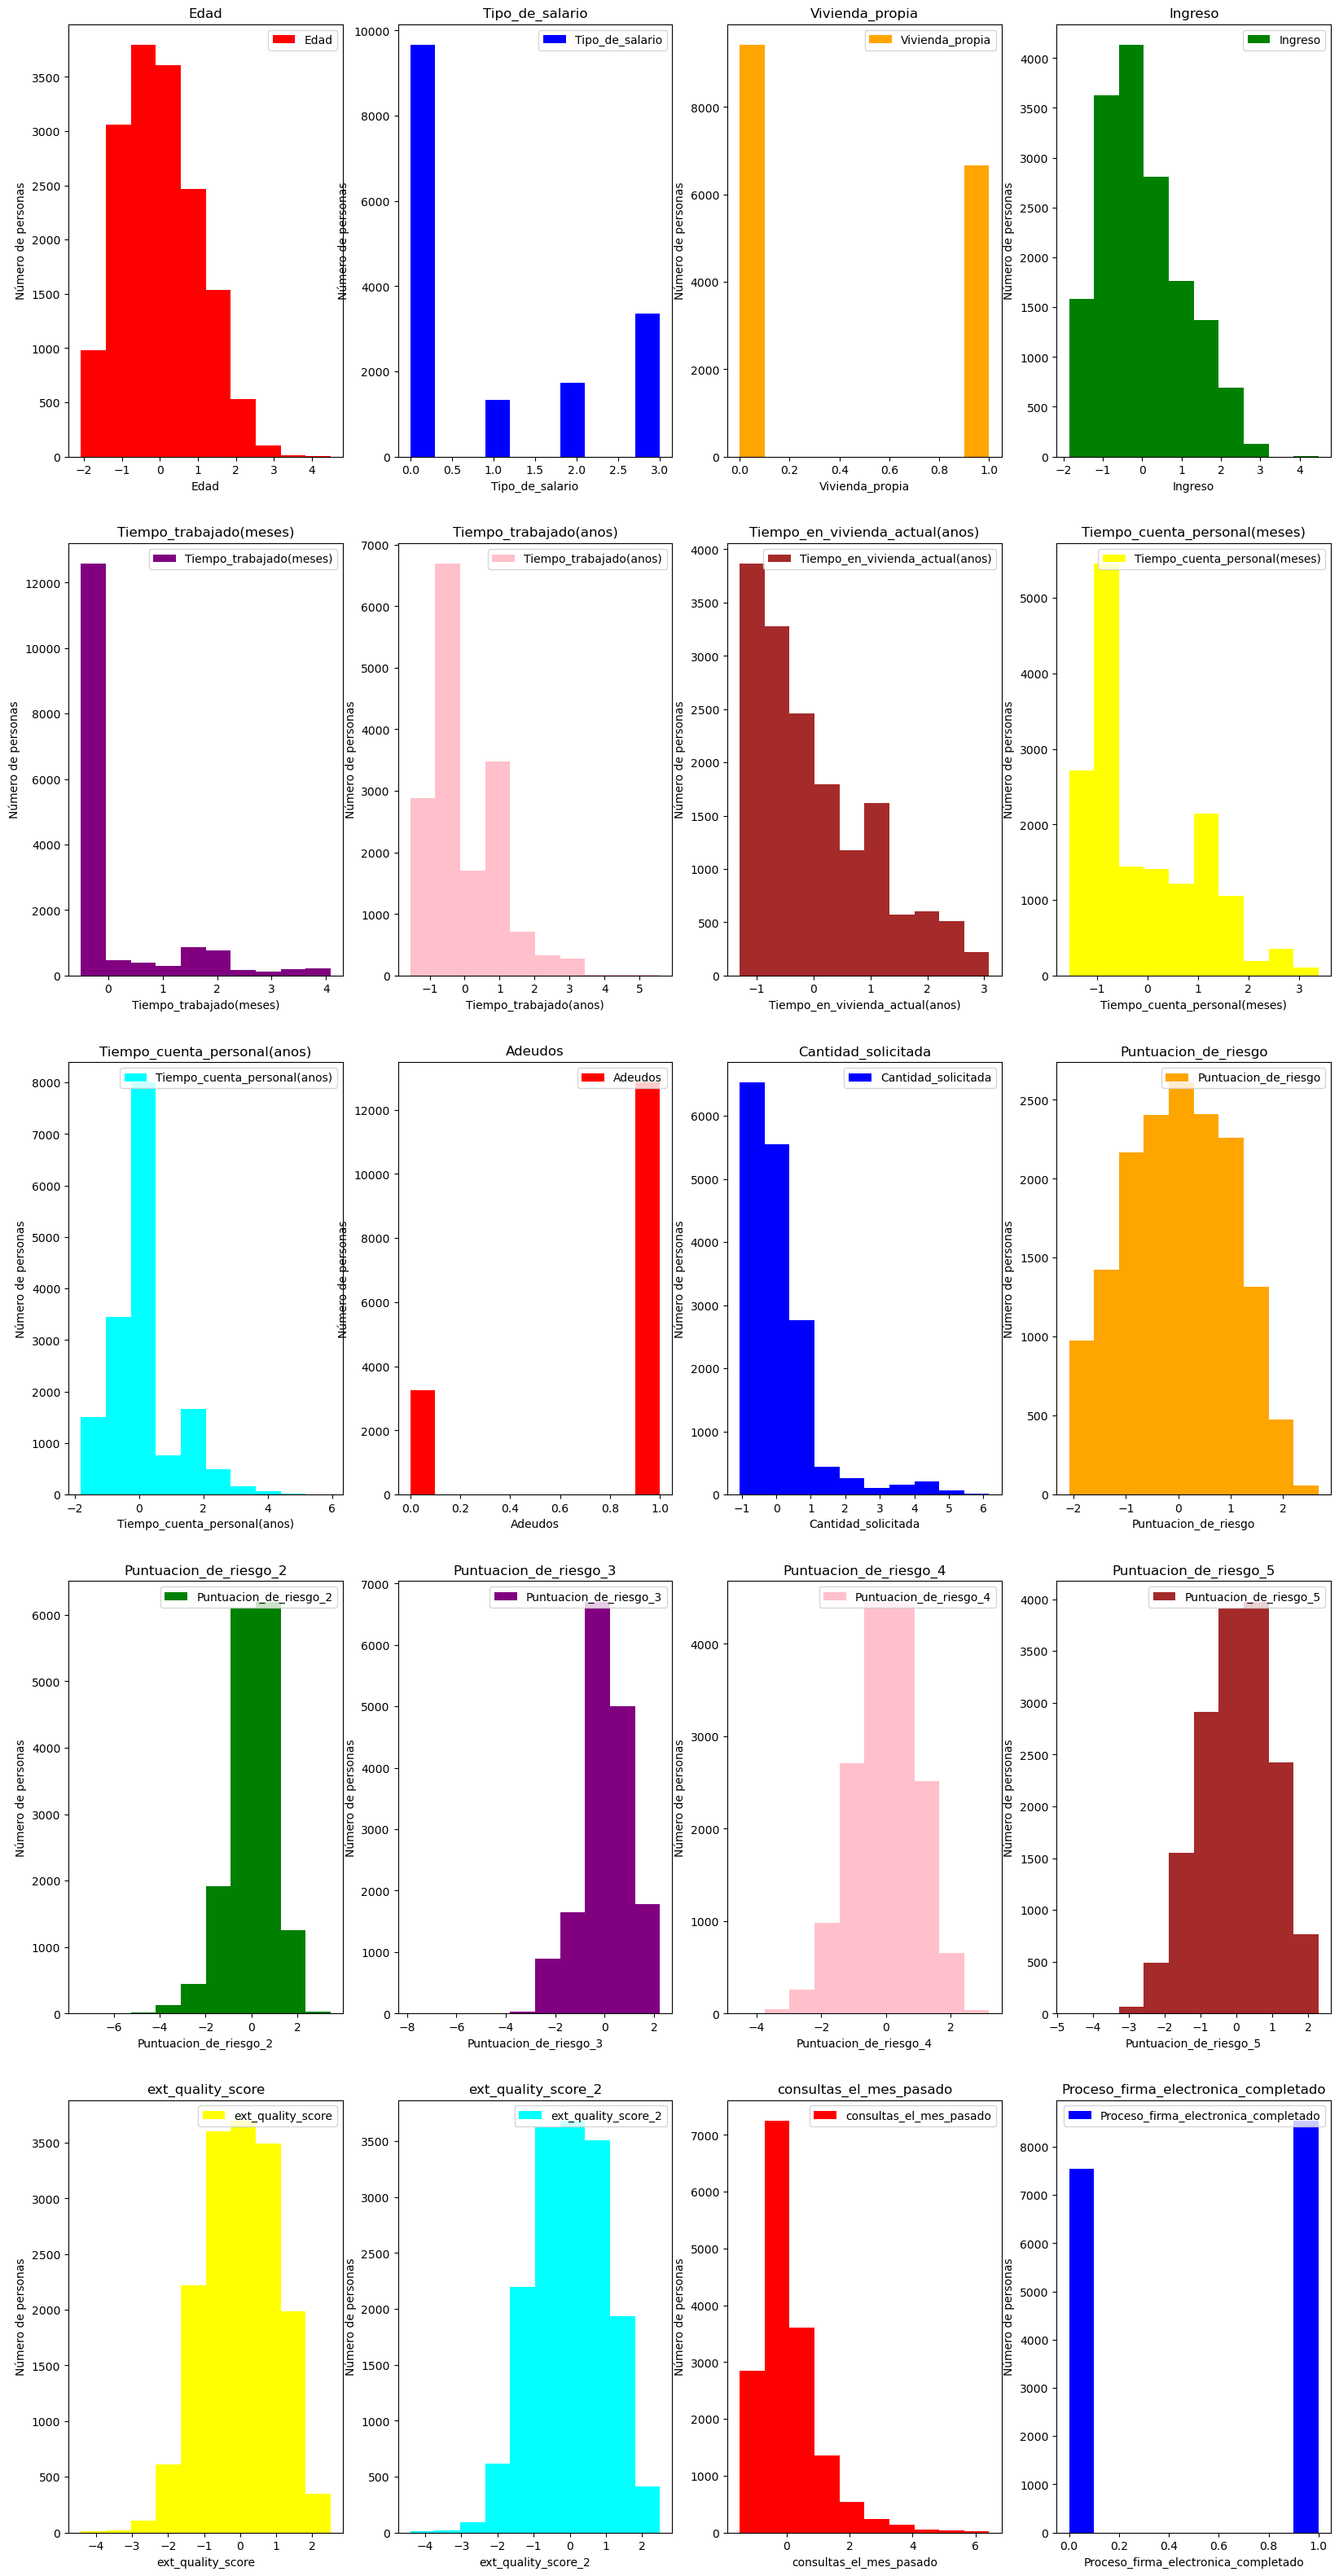

In [219]:
histograma()

## Diagramas de caja (poner los datos individualmente)

### ¿Qué es?

Un diagrama de caja es un método para representar gráficamente una serie de datos numéricos a través de sus cuartiles. De esta manera, se muestran a simple vista la mediana y los cuartiles de los datos, y también pueden representarse sus valores atípicos (altamente dispersos).

### ¿Qué es la dispersión?

Se refiere a cuanta distancia del centro se encuentran los datos

### ¿Cómo interpretar el gráfico?

#### Primer cuartil

El 25% de los valores son menores o igual a este valor. **En los gráficos del dataframe, este valor se representa en la parte inferior, en la linea que forma la caja.**

#### Mediana o Segundo Cuartil

Divide en dos partes iguales la distribución. De forma que  el 50% de los valores son menores o igual a este valor.**Este valor se representa en la linea verde que se encuentra dentro de la caja.**

#### Tercer cuartil
El 75% de los valores son menores o igual a este valor.**Se representa por la linea superior que dibuja la caja.**

#### Rango Intercuartílico (IQR)
Diferencia entre el valor del tercer cuartil y el primer cuartil. **Formula  IQR = Q3 - Q1** 

#### Lineas que se extienden más haya de la caja

Son los puntos más alejados que aún se consideran valores típicos( es decir, que se encuentran a menos de 1.5 IQR de los cuartiles), más haya de esas lineas divisoras, se encuentran los puntos que representan los valores atipicos con los que cuentan las columnas.

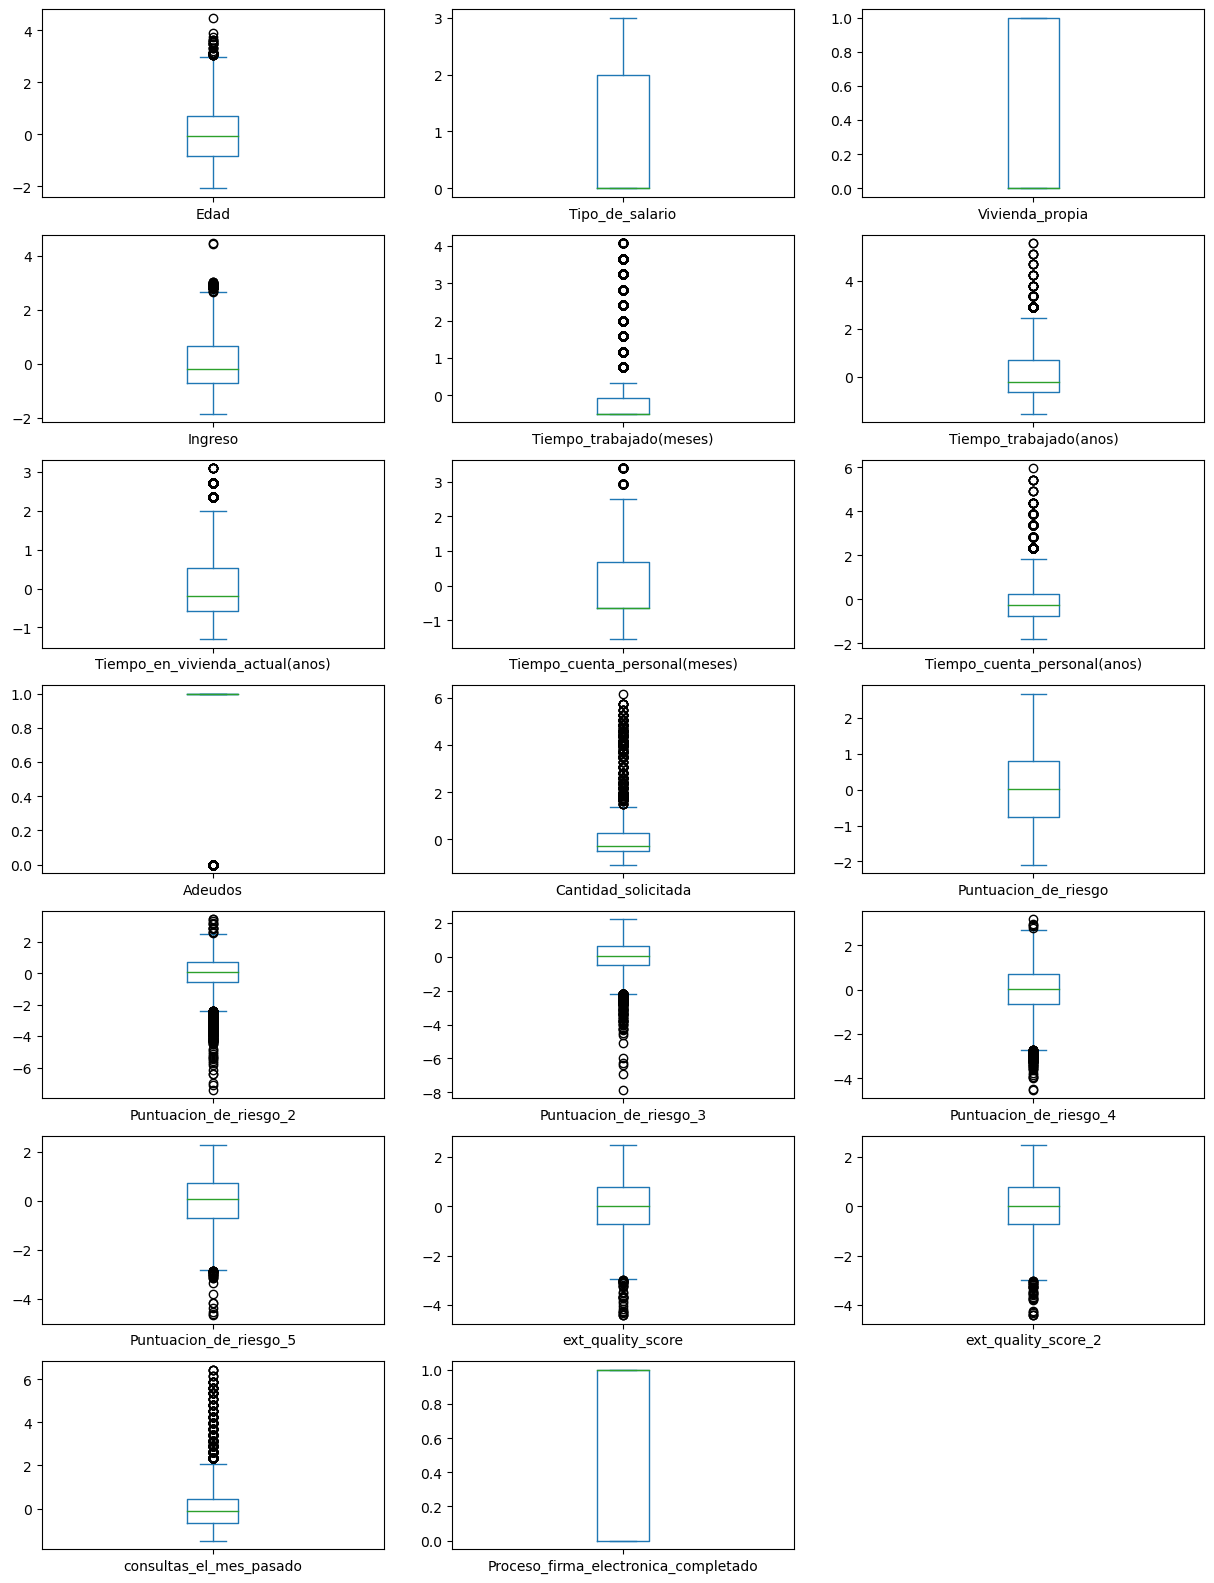

In [220]:
df.plot(kind="box", subplots=True, layout=(7,3), sharex=False, sharey=False, figsize=(15,20))
plt.show()

## Matriz de correlación

### ¿Qué es la correlación?

Es una medida estadística que expresa hasta qué punto dos variables están relacionadas linealmente.

### ¿Para qué sirve?

* La correlación es útil para describir relaciones simples entre datos. 
* Para la predicción de una variable (regresión lineal).

### Limitaciones 

Es importante saber que la correlación no nos informa sobre causas y efectos (Cuales son las variables dependientes e independientes).

In [225]:
lista_columnas = ['Edad','Tipo_de_salario','Ingreso','Tiempo_en_vivienda_actual(anos)','Tiempo_trabajado(meses)','Adeudos','Cantidad_solicitada','Puntuacion_de_riesgo']
matriz_correlacion = df[lista_columnas].corr()

Text(0.5, 1.0, 'Mapa de calor - Matriz de Correlación')

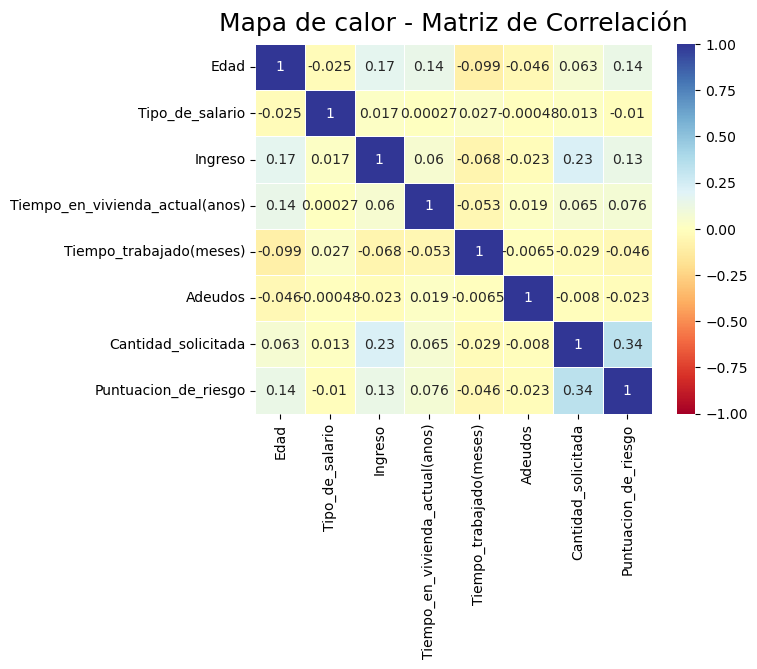

In [226]:
#plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(matriz_correlacion, vmin=-1, vmax=1, annot=True, cmap='RdYlBu', linewidth=.5)
heatmap.set_title('Mapa de calor - Matriz de Correlación', fontdict={'fontsize':18}, pad=10)

### ¿Qué significan los números de las correlaciones?

La correlación se describe mediante una medida sin unidades llamada coeficiente de correlación, que va desde -1 a +1.

* 1 = Existe una correlación directa fuerte.
* -1 = Existe una correlación inversa fuerte. 
* 0 = No existe una correlación lineal (Solamente no existe una relación lineal, puede que tengan otro tipo de relación los datos).

### ¿Cómo interpretar los resultados de los coeficientes?

A la hora de interpretar los valores del coeficiente de correlación de Pearson (Tabla de arriba), se pueden utilizar los siguientes criterios.

- Entre 0 y 0,10: correlación inexistente
- Entre 0,10 y 0,29: correlación débil
- Entre 0,30 y 0,50: correlación moderada
- Entre 0,50 y 1,00: correlación fuerte

Esto mismo aplica de forma negativa (inversa).

### ¿Cómo interpretar los resultados del gráfico? ( Agregar mas información, cambiar el significado de colores si se cambian)

En el gráfico que muestra la matriz de correlación, se le aplico colores que pasen del rojo, amarillo en el cero, hasta azul, para poder visualizar los coeficientes tanto bajos, nulos y altos respectivamente.

Por ejemplo, se puede ver que existe una correlación nula entre los adeudos de una persona y su edad correspondiente.

## Seleccionando características

### Separación de los datos
Es importante (o al menos recomendable) que antes de comenzar con el procesamiento de datos, se separe el conjunto de datos con las variables dependientes e independientes.

In [227]:
# Datos de entrada o independientes
# Por el momento todas
X = df.iloc[:,:-1]
X.head()

Edad                               16092
Tipo_de_salario                    16092
Vivienda_propia                    16092
Ingreso                            16092
Tiempo_trabajado(meses)            16092
Tiempo_trabajado(anos)             16092
Tiempo_en_vivienda_actual(anos)    16092
Tiempo_cuenta_personal(meses)      16092
Tiempo_cuenta_personal(anos)       16092
Adeudos                            16092
Cantidad_solicitada                16092
Puntuacion_de_riesgo               16092
Puntuacion_de_riesgo_2             16092
Puntuacion_de_riesgo_3             16092
Puntuacion_de_riesgo_4             16092
Puntuacion_de_riesgo_5             16092
ext_quality_score                  16092
ext_quality_score_2                16092
consultas_el_mes_pasado            16092
dtype: int64

In [229]:
# Datos de salida o dependientes
# Solamente la columna de firma electronica
y = df.iloc[:,-1]
y.head()

0    1
1    0
2    0
3    1
4    0
Name: Proceso_firma_electronica_completado, dtype: int64

### Método de filtro 
Esto es utilizado para clasificar las caracteristicas de los datos segun sus puntajes estaidisticos.
El metodo regularmente es: 
Conjunto de caracteristicas -> Seleccion del mejor subconjunto -> Aplicacion del algoritmo -> Evaluacion del rendimiento.

# Seleccionando características
# Se pueden cambiar el número de caracteristicas
# Extraccion de caracteristicas : chi-cuadrado
prueba = SelectKBest(score_func=chi2, k=5)
entrenamiento = prueba.fit(X.values, y.values)

# Puntaje de caracteristicas: chi- cuadrado
print("puntaje")
np.set_printoptions(precision=3)
print(entrenamiento.scores_)

# Caracteristicas seleccionadas
print("Caracteristicas seleccionadas")
caracteristicas = entrenamiento.transform(X.values)
print(caracteristicas[0:5,:])
caracteristicas_df = pd.DataFrame(data=caracteristicas, columns=list('ABCDE'))
caracteristicas_df.head()


In [230]:
#X.head()
df.head()

,Edad,Tipo_de_salario,Vivienda_propia,Ingreso,Tiempo_trabajado(meses),Tiempo_trabajado(anos),Tiempo_en_vivienda_actual(anos),Tiempo_cuenta_personal(meses),Tiempo_cuenta_personal(anos),Adeudos,Cantidad_solicitada,Puntuacion_de_riesgo,Puntuacion_de_riesgo_2,Puntuacion_de_riesgo_3,Puntuacion_de_riesgo_4,Puntuacion_de_riesgo_5,ext_quality_score,ext_quality_score_2,consultas_el_mes_pasado,Proceso_firma_electronica_completado
0,-0.225199,0,1,-0.252059,-0.498181,-0.214983,-0.203549,1.142375,-0.772647,1,-0.615650,-1.644706,0.515930,0.472052,-0.748358,-1.659955,-0.300449,-1.736552,0.969129,1
1,1.542596,3,0,-0.216595,-0.498181,1.121765,-0.203549,-0.650836,1.811407,1,-0.504402,-2.057400,0.528284,0.057394,1.057034,0.908993,0.779208,0.066139,0.695965,0
2,-1.656271,3,0,-1.509064,1.999371,-1.551731,-1.300135,1.590677,-1.289458,1,-0.838147,-1.757259,-0.533094,-2.053139,0.109945,0.378379,-0.655088,-0.648350,0.149636,0
3,-0.225199,0,0,1.398990,-0.498181,1.121765,-0.934606,-0.650836,1.811407,1,-0.281905,-1.238834,-0.286072,1.528766,1.492200,0.515315,1.224845,-0.209299,0.422800,1
4,-0.814464,2,0,0.106522,-0.498181,0.676183,-0.569077,-0.650836,2.328218,1,0.608080,-0.440733,-0.817915,-0.375265,0.257671,-0.422369,0.879489,0.888197,1.515458,0


Agrupando los datos en un dataframe para ver mejor la información, observamos que las columnas seleccionadas por el método de filtrado son las siguientes:

1. Edad
2. Ingreso
3. Tiempo_cuenta_personal(meses)
4. Cantidad_solicitada
5. Puntuacion_de_riesgo

Por lo que solo preservaremos estas columnas en el dataframe de las variables independientes (X)

In [232]:
X = df[['Edad','Ingreso','Tiempo_cuenta_personal(meses)','Cantidad_solicitada','Puntuacion_de_riesgo']]
X.head()

,Edad,Ingreso,Tiempo_cuenta_personal(meses),Cantidad_solicitada,Puntuacion_de_riesgo
0,-0.225199,-0.252059,1.142375,-0.615650,-1.644706
1,1.542596,-0.216595,-0.650836,-0.504402,-2.057400
2,-1.656271,-1.509064,1.590677,-0.838147,-1.757259
3,-0.225199,1.398990,-0.650836,-0.281905,-1.238834
4,-0.814464,0.106522,-0.650836,0.608080,-0.440733


In [233]:
X.count()

Edad                             16092
Ingreso                          16092
Tiempo_cuenta_personal(meses)    16092
Cantidad_solicitada              16092
Puntuacion_de_riesgo             16092
dtype: int64

## Procesamiento de los datos

### Datos de entrenamiento y de prueba

In [238]:
# Separación de datos de entrenamiento y de prueba con 25% de ellos
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=0)

## Algoritmos de clasificación.

###  Regresión Logistica
Este es el algoritmo mas basico de todos, sin embargo, es tambien de los mas utilizados ya que es de los mas faciles de implementar y se puede usar como linea base para cualquier problema de clasificacion.

In [239]:
modelo = LogisticRegression()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

In [240]:
print("Datos de entrenamiento")
print(y_test)
print()
print("Datos obtenidos en la predicción")
print(y_pred)

Datos de entrenamiento
[1 1 0 ... 0 0 1]

Datos obtenidos en la predicción
[0 1 0 ... 1 1 1]


#### Métricas de rendimiento del algoritmo  

##### Matriz de confusión
Es de las métricas de medicion mas sencillas de usar, sirve para comprobar la precision y exactitud del modelo usado y se usa cuando el problema de clasificacion tiene 2 o mas tipos de clases.

In [241]:
matriz_confusion = confusion_matrix(y_test, y_pred)
print(matriz_confusion)


[[ 663  850]
 [ 529 1177]]


##### Reporte de clasificación 
Este permite dar rapidamente una idea de la precision de un modelo mediante una serie de medidas, muestra la precision, sensibilidadm puntuacion F1, y el soporte para cada clase.

In [242]:
reporte_clasificacion = classification_report(y_test, y_pred)
print(reporte_clasificacion) 

              precision    recall  f1-score   support

           0       0.56      0.44      0.49      1513
           1       0.58      0.69      0.63      1706

    accuracy                           0.57      3219
   macro avg       0.57      0.56      0.56      3219
weighted avg       0.57      0.57      0.56      3219



##### Area bajo la curva
Permite medir el rendimiento del modelo de clasificacion, y es de hecho, una de las metricas mas importantes para esto.

In [243]:
area_bajo_la_curva = roc_auc_score(y_test, y_pred)
print(area_bajo_la_curva)

0.5640600919425162


### K vecinos más cercanos
Es un algoritmo de aprendizaje no parametrico.
Es decir que la estructura del modelo se determina a partir del conjunto, esto siendo util en la practica para cuando los conjuntos no siguen suposiciones logico-matematicas.

In [244]:
modelo = KNeighborsClassifier()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

d:\Ismael\Programas\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [245]:
print("Datos de entrenamiento")
print(y_test)
print()
print("Datos obtenidos en la predicción")
print(y_pred)

Datos de entrenamiento
[1 1 0 ... 0 0 1]

Datos obtenidos en la predicción
[0 1 0 ... 1 0 1]


#### Métricas de rendimiento del algoritmo

##### Matriz de confusión

In [246]:
matriz_confusion = confusion_matrix(y_test, y_pred)
print(matriz_confusion)

[[ 798  715]
 [ 669 1037]]


##### Reporte de clasificación 

In [247]:
reporte_clasificacion = classification_report(y_test, y_pred)
print(reporte_clasificacion) 

              precision    recall  f1-score   support

           0       0.54      0.53      0.54      1513
           1       0.59      0.61      0.60      1706

    accuracy                           0.57      3219
   macro avg       0.57      0.57      0.57      3219
weighted avg       0.57      0.57      0.57      3219



##### Area bajo la curva

In [248]:
area_bajo_la_curva = roc_auc_score(y_test, y_pred)
print(area_bajo_la_curva)

0.567641789911428


### Máquinas de vectores de soporte
Estas buscan la linea que mejor separa dos clases.
Las caracteristicas de datos que estan mas cerca de la linea que mejor separa las clases se denominan vectores de soporte e influyen en la ubicación de la línea.

In [249]:
modelo = SVC()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

In [250]:
print("Datos de entrenamiento")
print(y_test)
print()
print("Datos obtenidos en la predicción")
print(y_pred)

Datos de entrenamiento
[1 1 0 ... 0 0 1]

Datos obtenidos en la predicción
[1 1 1 ... 0 1 1]


####  Métricas de rendimento del algoritmo

##### Matriz de confusión

In [251]:
matriz_confusion = confusion_matrix(y_test, y_pred)
print(matriz_confusion)

[[ 713  800]
 [ 449 1257]]


##### Reporte de clasificación

In [252]:
reporte_clasificacion = classification_report(y_test, y_pred)
print(reporte_clasificacion) 

              precision    recall  f1-score   support

           0       0.61      0.47      0.53      1513
           1       0.61      0.74      0.67      1706

    accuracy                           0.61      3219
   macro avg       0.61      0.60      0.60      3219
weighted avg       0.61      0.61      0.60      3219



##### Area bajo la curva 

In [253]:
area_bajo_la_curva = roc_auc_score(y_test, y_pred)
print(area_bajo_la_curva)

0.6040302141115412


### Naive bayes
Esta tecnica de clasificacion estadistica se basa en el teorema de Bayes, y es uno de los algoritmos mas simples, siendo a su vez rapido, preciso y fiable, con una alta precision y velocidad en conjuntos grandes de datos.

In [254]:
modelo = GaussianNB()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

In [255]:
print("Datos de entrenamiento")
print(y_test)
print()
print("Datos obtenidos en la predicción")
print(y_pred)

Datos de entrenamiento
[1 1 0 ... 0 0 1]

Datos obtenidos en la predicción
[0 1 0 ... 0 1 1]


#### Métricas de rendimiento del algoritmo

##### Matriz de confusión 

In [256]:
matriz_confusion = confusion_matrix(y_test, y_pred)
print(matriz_confusion)

[[980 533]
 [901 805]]


##### Reporte de clasificación 

In [257]:
reporte_clasificacion = classification_report(y_test, y_pred)
print(reporte_clasificacion) 

              precision    recall  f1-score   support

           0       0.52      0.65      0.58      1513
           1       0.60      0.47      0.53      1706

    accuracy                           0.55      3219
   macro avg       0.56      0.56      0.55      3219
weighted avg       0.56      0.55      0.55      3219



##### Área bajo la curva

In [ ]:
area_bajo_la_curva = roc_auc_score(y_test, y_pred)
print(area_bajo_la_curva)

0.5557064519752255


### Árboles de decisión de clasificación 
En esta técnica, se dividen los datos en dos o más conjuntos homogéneos basados en el diferenciador más significativos en las variables de entrada. El árbol de decisión identifica la variable más significativa y su valor que proporciona los mejores conjuntos homogéneos de población. Todas las variables de entrada y todos los puntos de división posibles se evalúan y se elige la que tenga mejor resultado.

In [258]:
modelo = DecisionTreeClassifier()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

In [259]:
print("Datos de entrenamiento")
print(y_test)
print()
print("Datos obtenidos en la predicción")
print(y_pred)

Datos de entrenamiento
[1 1 0 ... 0 0 1]

Datos obtenidos en la predicción
[0 1 0 ... 0 1 1]


#### Métricas de rendimiento del algoritmo  

##### Matriz de confusión

In [260]:
matriz_confusion = confusion_matrix(y_test, y_pred)
print(matriz_confusion)

[[838 675]
 [725 981]]


##### Reporte de clasificación 


In [261]:
reporte_clasificacion = classification_report(y_test, y_pred)
print(reporte_clasificacion) 

              precision    recall  f1-score   support

           0       0.54      0.55      0.54      1513
           1       0.59      0.58      0.58      1706

    accuracy                           0.57      3219
   macro avg       0.56      0.56      0.56      3219
weighted avg       0.57      0.57      0.57      3219



##### Area bajo la curva

In [262]:
area_bajo_la_curva = roc_auc_score(y_test, y_pred)
print(area_bajo_la_curva)

0.5644478993699775


### Bosques Aleatorios.
Es un tipo de método de aprendizaje por conjuntos, donde un grupo de modelos débiles se combinan para formar un modelo poderoso.
En los boques aleatorios se cultivan varios árboles en lugar de un solo árbol. Para clasificar un nuevo objeto basado en atributos, cada árbol da una clasificación y se dice que el árbol “vota” por esa clase. El bosque elige la clasificación con más votos, sobre todos los árboles en el bosque.

In [263]:
modelo = RandomForestClassifier()
modelo.fit(X_train, y_train)
y_pred = modelo.predict(X_test)

In [264]:
print("Datos de entrenamiento")
print(y_test)
print()
print("Datos obtenidos en la predicción")
print(y_pred)

Datos de entrenamiento
[1 1 0 ... 0 0 1]

Datos obtenidos en la predicción
[0 1 1 ... 1 1 1]


####  Métricas de rendimento del algoritmo

##### Matriz de confusión

In [265]:
matriz_confusion = confusion_matrix(y_test, y_pred)
print(matriz_confusion)

[[ 862  651]
 [ 628 1078]]


##### Reporte de clasificación

In [266]:
reporte_clasificacion = classification_report(y_test, y_pred)
print(reporte_clasificacion) 

              precision    recall  f1-score   support

           0       0.58      0.57      0.57      1513
           1       0.62      0.63      0.63      1706

    accuracy                           0.60      3219
   macro avg       0.60      0.60      0.60      3219
weighted avg       0.60      0.60      0.60      3219



##### Area bajo la curva 

In [267]:
area_bajo_la_curva = roc_auc_score(y_test, y_pred)
print(area_bajo_la_curva)

0.6008082356195504


Observando los datos anterior podemos ver que cada uno de los algoritmos nos ofrecen resultados similares, por lo que no importaria cual seleccionemos, en nuestro caso el primero de Regresión logística seria suficiente ya que cumple con la clasificación de tipo binario.

En cuanto al porcentaje de precisión del procedimiento se puede considerar un poco bajo, sin embargo sobrepasa el 50 por ciento de aciertos con respecto a los datos de prueba que le dimos, quiza esto cambiaria al darle menor cantidad de caracteristicas a evaluar ya que esto influye muchisimo, en cuanto más características coloquemos, más ruido tendran los datos, sin embargo, no consideramos adecuado que todo un dataset se evalue, realizando predicciones con pocas características, ya que de cierta manera, todo influye realmente, en este caso, para el proceso de firma electronica.